In [22]:
import math
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import pandas as pd
import matplotlib.pyplot as plt
import collections, heapq, itertools, math, textwrap
import networkx as nx
import itertools
import ast  

In [3]:
# Arithmetic Coding algorithms

# Arithmetic Coding algorithms

## Scaling and incremental coding

In [36]:
# Parameters
BITS = 32                       
MAX_RANGE = 1 << BITS
HALF = MAX_RANGE >> 1           
QTR = HALF   >> 1              
THREE_QTR = QTR   * 3                

class BitBuffer:
    def __init__(self):
        self.out: List[int] = []
        self._pending = 0             

    def write_bit(self, bit: int):
        self.out.append(bit)
        
        # pending битүүдийг бичих
        while self._pending:
            self.out.append(bit ^ 1) 
            self._pending -= 1

    def underflow_pending(self):
        self._pending += 1

    def bits(self) -> str:
        return "".join(str(b) for b in self.out)

def build_model(text: str):
    freqs = collections.Counter(text)
    total = sum(freqs.values())
    symbols = sorted(freqs)
    cum_low = {}
    cum_high = {}
    cum = 0
    for s in symbols:
        cum_low[s] = cum
        cum += freqs[s]
        cum_high[s] = cum
    return freqs, total, cum_low, cum_high, symbols

history = []

def arithmetic_encode(text: str) -> Tuple[str, List[int], dict]:
    freqs, total, cum_low, cum_high, symbols = build_model(text)

    low, high = 0, MAX_RANGE - 1
    buf = BitBuffer()

    for ch in text:
        history.append((low, high))

        # хүрээг нарийсгах
        range_ = high - low + 1
        high = low + (range_ * cum_high[ch] // total) - 1
        low = low + (range_ * cum_low[ch]  // total)

        # renormalise — E1, E2, E3
        while True:
            if high < HALF:             # E1
                buf.write_bit(0)
                low  <<= 1
                high = (high << 1) | 1
            elif low >= HALF:           # E2
                buf.write_bit(1)
                low  = (low  - HALF) << 1
                high = ((high - HALF) << 1) | 1
            elif low >= QTR and high < THREE_QTR:  # E3: underflow
                buf.underflow_pending()
                low  = (low  - QTR) << 1
                high = ((high - QTR) << 1) | 1
            else:
                break
    buf.underflow_pending()            
    if low < QTR:
        buf.write_bit(0)
    else:
        buf.write_bit(1)

    return buf.bits(), symbols, {"total": total, "cum_low": cum_low, "cum_high": cum_high}


def arithmetic_decode(bits: str, length: int, model: dict) -> str:
    total = model["total"]
    cum_low = model["cum_low"]
    cum_high = model["cum_high"]
    symbols = sorted(cum_low)

    low, high = 0, MAX_RANGE - 1
    value = 0

    bit_iter   = (int(b) for b in bits)
    for _ in range(BITS):
        value = (value << 1) | next(bit_iter, 0)

    out = []
    for _ in range(length):
        range_ = high - low + 1
        scaled = ((value - low + 1) * total - 1) // range_  
        for s in symbols:
            if cum_high[s] > scaled >= cum_low[s]:
                ch = s
                break
        out.append(ch)

        high = low + (range_ * cum_high[ch] // total) - 1
        low  = low + (range_ * cum_low[ch]  // total)

        while True:
            if high < HALF:
                pass  
            elif low >= HALF:
                low  -= HALF
                high -= HALF
                value -= HALF
            elif low >= QTR and high < THREE_QTR:
                low  -= QTR
                high -= QTR
                value -= QTR
            else:
                break
            low   <<= 1
            high  = (high << 1) | 1
            value = (value << 1) | next(bit_iter, 0)

    return "".join(out)

In [35]:
txt = "Tuguldur Bayarsaikhan"

bitstream, symbols, model = arithmetic_encode(txt)
print("Encoded bits:", bitstream)

recovered = arithmetic_decode(bitstream, len(txt), model)
print("Decoded: ", recovered == txt)

Encoded bits: 001000101111110010101010011000101110011111101010100000010110011101101101011010
Decoded:  True


In [37]:
def plot_ranges(history, max_steps=25):
    # хамгийн сүүлийн түүхийг авах
    show = history[:max_steps]

    xs = [(lo / MAX_RANGE, hi / MAX_RANGE) for lo, hi in show]

    fig, ax = plt.subplots(figsize=(6, 0.4 * len(xs)))

    for i, (lo, hi) in enumerate(xs[::-1]):

        ax.hlines(i, lo, hi, linewidth=8)

        ax.text(hi, i, f" [{lo:.6f}, {hi:.6f})",
                fontsize=8, va="center")

    ax.set_ylim(-1, len(xs))
    ax.set_yticks(range(len(xs))[::-1], labels=[f"Step {k}" for k in range(len(xs))])
    ax.set_xlim(0, 1)
    ax.set_xlabel("Normalised range")
    ax.set_title("Arithmetic-coding range narrowing")
    ax.invert_yaxis()    
    plt.tight_layout()
    plt.show()

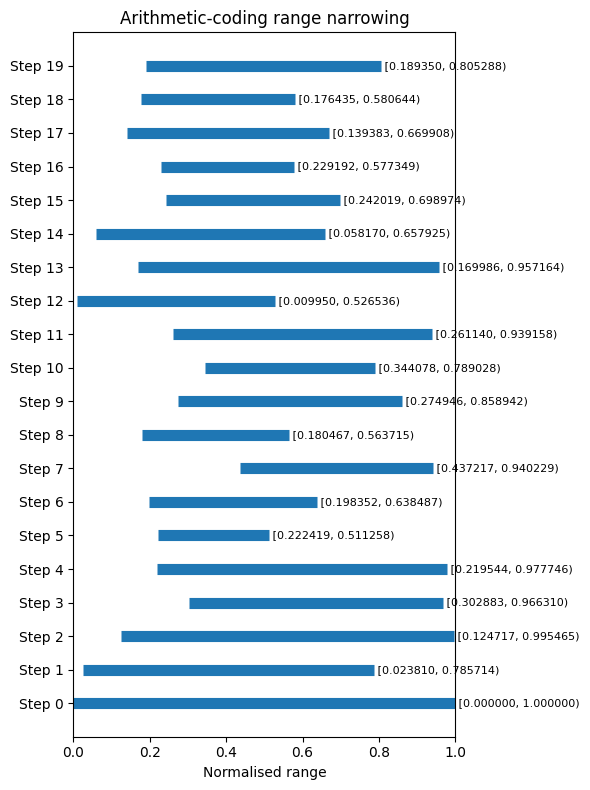

In [38]:
bits, symbols, model = arithmetic_encode(txt)    
# print("encoded bits:", bits)

plot_ranges(history, max_steps=20)                

# Variable Length Encoding

# Shannon-Fano algorithm

In [39]:
class ShannonFano:
  """Shannon-Fano coding algorithm"""

  def __init__(self, text: str) -> None:
    # Үсэгнүүдийн давтамж, магадлал, битийн хүснэгт хадгалах
    self.freqs = {}
    self.probs = {}
    self.codedict = {}

    self.fit(text)

  def fit(self, text: str) -> None:
    # Өгөгдсөн текст дээр алгоритмыг ачааллуулах

    self._compute_frequencies(text)
    self._compute_probabilities()
    self._build_codedict()

  def encode(self, text: str) -> str:
    # Өгөгдсөн текстийг битийн мөр болгон хувиргах

    return "".join(self.codedict[char] for char in text)
  
  def decode(self, bits: str) -> str:
    # Битийн мөрийг анхны текст рүү хөрвүүлэх

    rev = {code: sym for sym, code in self.codedict.items()}

    buffer, output = "", []

    # Битийн мөрийг битийн хүснэгттэй харьцуулах
    for b in bits:
      buffer += b
      if buffer in rev:
        output.append(rev[buffer])
        buffer = ""

    return "".join(output)

  @property
  def entropy(self) -> float:
    # Мэдээллийн энтропи буюуу доод хязгаар

    return -sum(p * math.log2(p) for p in self.probs.values())

  @property
  def avg_length(self) -> float:
    # Дундаж битийн урт

    return sum(self.probs[s] * len(c) for s, c in self.codedict.items())

  def dataframe(self) -> pd.DataFrame:
    # Давтамж, магадлал, битийн хүснэгтийг dataFrame-д хадгалах
    records = []

    for sym, p in sorted(self.probs.items(), key=lambda x: -x[1]):
        records.append({
            "Symbol": repr(sym),
            "Count": self.freqs[sym],
            "Probability": round(p, 4),
            "Code": self.codedict[sym],
            "Code Length": len(self.codedict[sym]),
        })

    return pd.DataFrame(records)
  
  # def summary(self) -> None:
  #       """Хураангуй хүснэгт хэвлэх."""
  #       df = self.dataframe()
  #       print(df.to_string(index=False))
  #       print("\nМэдээллийн =", f"{self.entropy:.3f}", "bits/symbol")
  #       print("Дундаж битийн урт =", f"{self.avg_length:.3f}", "bits/symbol")

  def summary(self) -> None:
    # Кодын үр дүнг хэвлэх
    print("Үсэг | Давтамж | Магадлал | Битлэх")

    for sym, p in sorted(self.probs.items(), key=lambda x: -x[1]):
      
      print(f"{repr(sym):6}   |   {self.freqs[sym]:5}  |\
            {p:5.3f}   |   {self.codedict[sym]}")

    print(f"\nМэдээллийн энтропи = {self.entropy:.3f} bits/symbol")
    print(f"Дундаж битийн урт   = {self.avg_length:.3f} bits/symbol")

  def _compute_frequencies(self, text: str) -> None:
    # Үсэг бүрийн давтамжийг тооцоолох

    self.freqs = dict(Counter(text))

  def _compute_probabilities(self) -> None:
    # Үсэг бүрийн магадлалыг өмнөх олсон давтамжаа ашиглан тооцоолох

    total = sum(self.freqs.values())
    self.probs = {s: c / total for s, c in self.freqs.items()}

  def _build_codedict(self) -> None:  
    # Кодын хүснэгт үүсгэх
    self.codedict = {}

    symbols_sorted = sorted(self.probs.items(), key=lambda x: x[1], reverse=True)
    self._shannon_fano(symbols_sorted, "")

  def _shannon_fano(self, symbols: List[Tuple[str, float]],
                    prefix: str) -> None:
    
    """
    Рекурсив ашиглан магадлалаар хоёр хувааж,
    зүүн талд 0, баруун талд 1 залгах
    """
    # Суурь нөхцөл
    if len(symbols) == 1:
      sym = symbols[0][0]
      self.codedict[sym] = prefix or "0"
      return

    total = sum(p for _, p in symbols)

    cum, idx = 0.0, 0

    for i, (_, p) in enumerate(symbols):
      cum += p
      idx = i
      if cum >= total / 2:
        break
    
    left, right = symbols[:idx + 1], symbols[idx + 1:]
    self._shannon_fano(left,  prefix + "0")
    self._shannon_fano(right, prefix + "1")

In [40]:
ShannonFanoAlgo = ShannonFano(txt)

df = ShannonFanoAlgo.dataframe()
ShannonFanoAlgo.summary()

encoded = ShannonFanoAlgo.encode(txt)
print("\nEncoded bits:", encoded)

decoded = ShannonFanoAlgo.decode(encoded)
print("Decoded text :", decoded)

Үсэг | Давтамж | Магадлал | Битлэх
'a'      |       4  |            0.190   |   000
'u'      |       3  |            0.143   |   001
'r'      |       2  |            0.095   |   010
'T'      |       1  |            0.048   |   0110
'g'      |       1  |            0.048   |   0111
'l'      |       1  |            0.048   |   10000
'd'      |       1  |            0.048   |   10001
' '      |       1  |            0.048   |   1001
'B'      |       1  |            0.048   |   1010
'y'      |       1  |            0.048   |   1011
's'      |       1  |            0.048   |   11000
'i'      |       1  |            0.048   |   11001
'k'      |       1  |            0.048   |   1101
'h'      |       1  |            0.048   |   1110
'n'      |       1  |            0.048   |   1111

Мэдээллийн энтропи = 3.690 bits/symbol
Дундаж битийн урт   = 3.762 bits/symbol

Encoded bits: 0110001011100110000100010010101001101000010110000101100000011001110111100001111
Decoded text : Tuguldur Bayarsaikhan


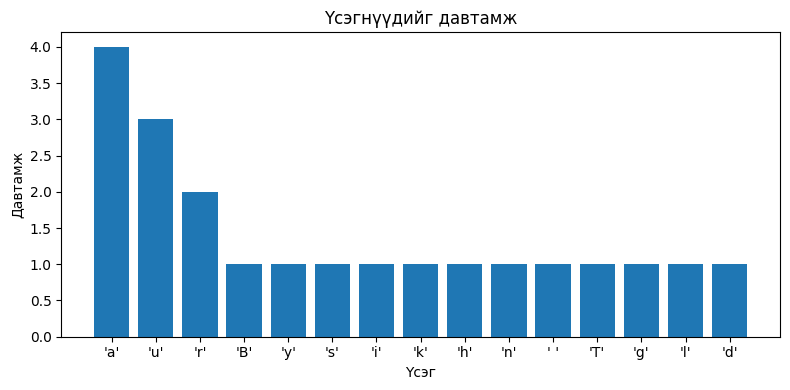

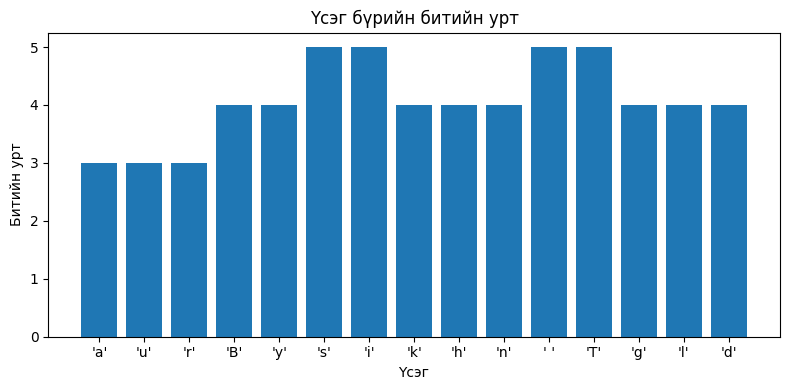

In [11]:
plt.figure(figsize=(8, 4))
plt.bar(df["Symbol"], df["Count"])
plt.title("Үсэгнүүдийг давтамж")
plt.xlabel("Үсэг")
plt.ylabel("Давтамж")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(df["Symbol"], df["Code Length"])
plt.title("Үсэг бүрийн битийн урт")
plt.xlabel("Үсэг")
plt.ylabel("Битийн урт")
plt.tight_layout()
plt.show()

In [7]:
def print_ascii_tree(codebook):

    prefixes = {""}

    for code in codebook.values():
        for i in range(1, len(code)):
            prefixes.add(code[:i])

    # Тухайн зангилааны хүүхдүүд (0, 1)
    children = {p: [] for p in prefixes}

    for p in prefixes:
        for bit in ("0", "1"):
            child = p + bit

            if any(c.startswith(child) for c in codebook.values()):
                children[p].append(child)

    lines = []
    def recurse(prefix, indent, is_last):

        label = "(root)" if prefix == "" else ""
        if prefix in codebook:
            sym = codebook[prefix]
            label = f"{sym} ({prefix})"

    #     joint = "└─" if is_last else "├─"

    #     if prefix != "":
    #         edge_bit = prefix[-1]
    #         lines.append(f"{indent}{joint}{edge_bit}─ {label}")
    #         indent += "   " if is_last else "│  "
    #     else:
    #         lines.append(label)

    #     kids = children.get(prefix, [])
    #     for idx, kid in enumerate(kids):
    #         recurse(kid, indent, idx == len(kids) - 1)

    # recurse("", "", True)
    # print("\n".join(lines))


In [8]:
sample_text = "Bayarsaikhan Tuguldur"
coder = ShannonFano(sample_text)

print_ascii_tree({v: k for k, v in coder.codedict.items()})

(root)


In [41]:
def draw_code_tree(df, zero_label="0", one_label="1") -> None:

    G = nx.DiGraph()
    root_id  = 0

    G.add_node(root_id, label="")         
    next_id = itertools.count(1)    

    child_map = {}              

    for _, row in df.iterrows():
        sym  = ast.literal_eval(row["Symbol"])
        code = row["Code"]

        current = root_id
        for bit in code:
            key = (current, bit)

            if key not in child_map:
                cid = next(next_id)
                child_map[key] = cid
                G.add_node(cid, label="")     
                G.add_edge(current, cid, bit=bit)

            current = child_map[key]

        G.nodes[current]["label"] = sym

    pos = hierarchy_pos(G, root_id)

    node_labels = {n: (G.nodes[n]["label"] or "") for n in G.nodes}

    edge_labels = {
        (u, v): (zero_label if d["bit"] == "0" else one_label)
        for u, v, d in G.edges(data=True)
    }

    nx.draw(G, pos, with_labels=True, labels=node_labels,
            node_color="lightgreen", node_size=800, font_size=14, arrows=False)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    plt.axis("off")
    plt.show()

def hierarchy_pos(G, root, width=1., vert_gap=.2, vert_loc=0, xcenter=.5):
    def helper(r, leftmost, w, vgap, vloc, xcent, pos=None, parent=None):

        if pos is None:
            pos = {r: (xcent, vloc)}
        else:
            pos[r] = (xcent, vloc)

        children = list(G.neighbors(r))
        if parent is not None and r in children:
            children.remove(parent)

        if children:
            dx = w / len(children)
            nextx = xcent - w / 2 - dx / 2
            for child in children:
                nextx += dx
                pos = helper(child, leftmost, dx, vgap, vloc - vgap, nextx, pos, r)
        return pos
    return helper(root, 0, width, vert_gap, vert_loc, xcenter)

   Symbol  Count  Probability   Code  Code Length
0     'a'      4       0.1905    000            3
1     'u'      3       0.1429    001            3
2     'r'      2       0.0952    010            3
3     'T'      1       0.0476   0110            4
4     'g'      1       0.0476   0111            4
5     'l'      1       0.0476  10000            5
6     'd'      1       0.0476  10001            5
7     ' '      1       0.0476   1001            4
8     'B'      1       0.0476   1010            4
9     'y'      1       0.0476   1011            4
10    's'      1       0.0476  11000            5
11    'i'      1       0.0476  11001            5
12    'k'      1       0.0476   1101            4
13    'h'      1       0.0476   1110            4
14    'n'      1       0.0476   1111            4


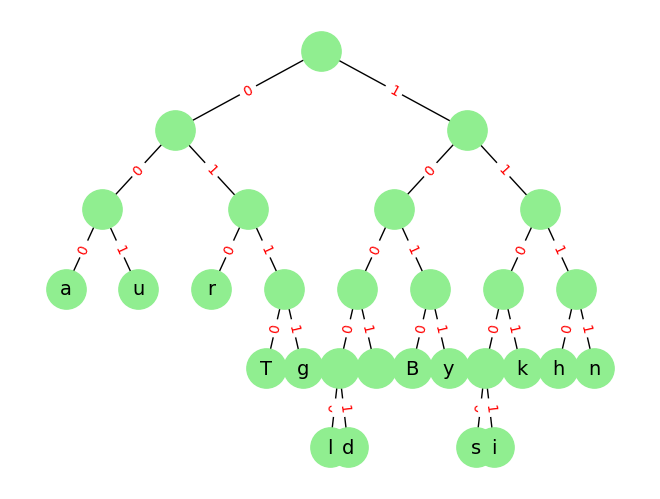

In [42]:
ShannonFanoAlgo = ShannonFano(txt)

df = ShannonFanoAlgo.dataframe()  
print(df)            
draw_code_tree(df)   

## Huffman Coding

In [43]:
class Node:
    """Модыг илэрхийлэх Node"""
    _ids = itertools.count() 

    def __init__(self, freq, char=None, left=None, right=None):

        # Давтамж, тэмдэгт, зүүн, баруун Node
        self.freq, self.char = freq, char
        self.left, self.right = left, right
        self.id = next(Node._ids)

    def __lt__(self, other):
        # Node бүтцийг харьцуулах

        return (self.freq, self.id) < (other.freq, other.id)

def build_huffman_tree(text: str) -> Node:
    # Huffman модыг тооцоолох

    freqs = collections.Counter(text)     

    heap = [Node(freq, char=ch) for ch, freq in freqs.items()]
    heapq.heapify(heap)                     

    # Суурь нөхцөл
    if len(heap) == 1:
        only = heapq.heappop(heap)
        heapq.heappush(heap, Node(only.freq, left=only, right=Node(0)))

    while len(heap) > 1:
        n1, n2 = heapq.heappop(heap), heapq.heappop(heap)
        heapq.heappush(heap, Node(n1.freq + n2.freq, left=n1, right=n2))

    return heap[0]                                     

def gen_codes(node: Node, prefix: str = "", codes=None) -> dict:
    """Модноос битийн хүснэгт гаргах"""

    if codes is None:
        codes = {}

    if node.char is not None:                           
        codes[node.char] = prefix or "0"               
    else:
        gen_codes(node.left,  prefix + "0", codes)
        gen_codes(node.right, prefix + "1", codes)

    return codes

def huffman_encode(text: str):
    """Мод, битийн хүснэгт, шифрлэгдсэн текстийг буцаах"""
    
    root = build_huffman_tree(text)
    codes = gen_codes(root)
    encoded = "".join(codes[ch] for ch in text)          
    return root, codes, encoded

In [44]:
root, codes, encoded = huffman_encode(txt)

freqs = collections.Counter(txt)
total = len(txt)

rows = [(ch, freq, f"{freq/total:.3f}", codes[ch]) for ch, freq in freqs.items()]

rows.sort(key=lambda x: (-x[1], x[0]))                  

col_widths = [5, 8, 11, 10]
header = ["Үсэг", "Давтамж", "Магадлал", "Битлэх"]

def fmt_row(cols):
    return " | ".join(str(c).ljust(w) for c, w in zip(cols, col_widths))

print(fmt_row(header))
print("-" * (sum(col_widths) + 9))
for ch, freq, prob, code in rows:
    visible = repr(ch)[1:-1] if ch == " " else ch  
    print(fmt_row([visible, freq, prob, code]))

entropy = -sum((f/total)*math.log2(f/total) for f in freqs.values())
avg_len = sum((f/total)*len(codes[ch]) for ch, f in freqs.items())

print("\nМэдээллийн энтропи =", f"{entropy:.3f}", "bits/symbol")
print("Дундаж битийн урт   =", f"{avg_len:.3f}", "bits/symbol\n")

print("Encoded bits:", encoded)

decoded, node = [], root

for bit in encoded:
    node = node.left if bit == "0" else node.right

    if node.char is not None:
        decoded.append(node.char)
        node = root
        
print("Decoded txt :", "".join(decoded))

Үсэг  | Давтамж  | Магадлал    | Битлэх    
-------------------------------------------
a     | 4        | 0.190       | 110       
u     | 3        | 0.143       | 101       
r     | 2        | 0.095       | 1110      
      | 1        | 0.048       | 0010      
B     | 1        | 0.048       | 0011      
T     | 1        | 0.048       | 11110     
d     | 1        | 0.048       | 0001      
g     | 1        | 0.048       | 11111     
h     | 1        | 0.048       | 1000      
i     | 1        | 0.048       | 0110      
k     | 1        | 0.048       | 0111      
l     | 1        | 0.048       | 0000      
n     | 1        | 0.048       | 1001      
s     | 1        | 0.048       | 0101      
y     | 1        | 0.048       | 0100      

Мэдээллийн энтропи = 3.690 bits/symbol
Дундаж битийн урт   = 3.762 bits/symbol

Encoded bits: 1111010111111101000000011011110001000111100100110111001011100110011110001101001
Decoded txt : Tuguldur Bayarsaikhan


In [45]:
def draw_huffman_nx(root: Node):
    
    G = nx.DiGraph()

    # Рекурсив ашиглан Node бүрийг Графт нэмэв
    def walk(node: Node):

        nid = str(id(node))
        G.add_node(nid, label=node.char)

        if node.left:
            lid = walk(node.left)
            G.add_edge(nid, lid, bit="0")               
        if node.right:
            rid = walk(node.right)
            G.add_edge(nid, rid, bit="1")    

        return nid

    walk(root)

    pos = hierarchy_pos(G, str(id(root)))

    node_labels = {n: (G.nodes[n]["label"] or "") for n in G.nodes}
    edge_labels = nx.get_edge_attributes(G, "bit")

    nx.draw(G, pos, with_labels=True, labels=node_labels,
            node_color="lightgreen", node_size=800, font_size=14, arrows=False)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    plt.axis("off")
    plt.show()

def hierarchy_pos(G, root, width=1., vert_gap=.2, vert_loc=0, xcenter=.5):
    def _hierarchy_pos(G, root, leftmost, width, vgap, vloc, xcent,
                       pos=None, parent=None):
        if pos is None:
            pos = {root: (xcent, vloc)}
        else:
            pos[root] = (xcent, vloc)

        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)

        if children:
            dx = width / len(children)
            nextx = xcent - width / 2 - dx / 2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, leftmost, dx, vgap,
                                     vloc - vgap, nextx, pos, root)
        return pos

    return _hierarchy_pos(G, root, 0, width, vert_gap, vert_loc, xcenter)

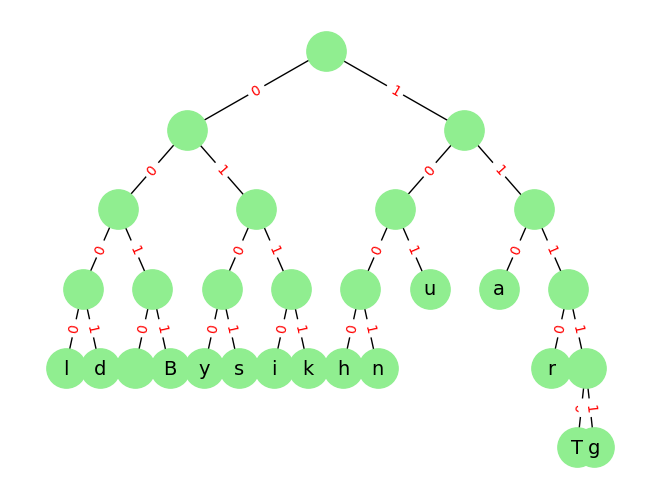

In [46]:
root = build_huffman_tree(txt)
draw_huffman_nx(root)

# Lossy JPEG

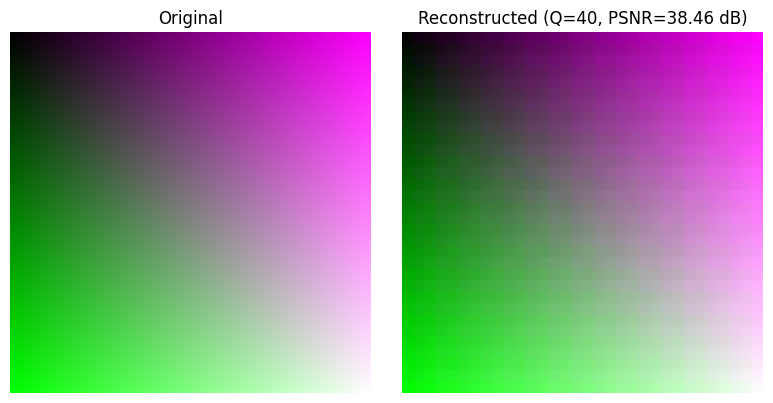

In [48]:
import numpy as np
from scipy.fftpack import dct, idct

def blockify(img, block=8):
    h, w = img.shape
    return img.reshape(h//block, block, w//block, block).swapaxes(1,2).reshape(-1, block, block)

def unblockify(blocks, h, w, block=8):
    bh = h//block
    bw = w//block
    arr = blocks.reshape(bh, bw, block, block).swapaxes(1,2).reshape(h, w)
    return arr

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Standard quantization matrices (luminance, chrominance)
QY = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]])

QC = np.array([
 [17,18,24,47,99,99,99,99],
 [18,21,26,66,99,99,99,99],
 [24,26,56,99,99,99,99,99],
 [47,66,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99]])

def scale_quant(Q, quality):
    if quality < 50 and quality > 1:
        S = 5000 / quality
    elif quality < 100:
        S = 200 - quality*2
    else:
        S = 1
    S /= 100.0
    return np.clip((Q * S + 0.5).astype(int), 1, 255)

def rgb2ycbcr(img):
    R, G, B = img[...,0], img[...,1], img[...,2]
    Y  =  0.299*R + 0.587*G + 0.114*B
    Cb = -0.1687*R - 0.3313*G + 0.5*B + 128
    Cr =  0.5*R - 0.4187*G - 0.0813*B + 128
    return np.stack((Y,Cb,Cr), axis=-1)

def ycbcr2rgb(img):
    Y, Cb, Cr = img[...,0], img[...,1], img[...,2]
    R = Y + 1.402*(Cr-128)
    G = Y - 0.344136*(Cb-128) - 0.714136*(Cr-128)
    B = Y + 1.772*(Cb-128)
    return np.stack((R,G,B), axis=-1).clip(0,255)

def jpeg_compress(channel, Q):
    h,w = channel.shape
    blocks = blockify(channel-128)
    dct_blocks = np.array([dct2(b) for b in blocks])
    Qb = dct_blocks / Q
    return np.round(Qb).astype(int), (h,w)

def jpeg_decompress(coeffs, Q, shape):
    Qb = coeffs * Q
    idct_blocks = np.array([idct2(b) for b in Qb])
    return unblockify(idct_blocks, *shape)+128

# ------------- Generate synthetic sample image ------------
h,w = 128,128
x = np.linspace(0,1,w)
y = np.linspace(0,1,h)[:,None]
grad = np.dstack((x*np.ones_like(y), y*np.ones_like(x), np.flipud(x*np.ones_like(y))))
img = (grad*255).astype(np.uint8)

# ------------- Full JPEG pipeline -------------------------
quality = 40
img_ycbcr = rgb2ycbcr(img).astype(float)

QYq = scale_quant(QY, quality)
QCq = scale_quant(QC, quality)

Yc, shape = jpeg_compress(img_ycbcr[...,0], QYq)
CbC, _ = jpeg_compress(img_ycbcr[...,1], QCq)
CrC, _ = jpeg_compress(img_ycbcr[...,2], QCq)

Yrec  = jpeg_decompress(Yc,  QYq,  shape)
CbRec = jpeg_decompress(CbC, QCq, shape)
CrRec = jpeg_decompress(CrC, QCq, shape)

recon = ycbcr2rgb(np.dstack((Yrec, CbRec, CrRec))).astype(np.uint8)

# ------------- Compute PSNR -------------------------------
mse = np.mean((img.astype(float)-recon.astype(float))**2)
psnr = 10*np.log10((255**2)/mse)

# ------------- Show results -------------------------------
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis('off')
axes[1].imshow(recon)
axes[1].set_title(f"Reconstructed (Q={quality}, PSNR={psnr:.2f} dB)")
axes[1].axis('off')
plt.tight_layout()
plt.show()